# Building regression model 

Explore how to predict verified status to help them understand how video characteristics relate to verified users and conduct a logistic regression using verified status as the outcome variable.

## Import data 

In [4]:
# Import packages for data manipulation
import pandas as pd 
import numpy as np 

# Import packages for data visualization
import matplotlib.pyplot as plt
%pip install seaborn
import seaborn as sns

# Import packages for data preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.utils import resample

# Import packages for data modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Load dataset 

In [10]:
# Load dataset into dataframe
data = pd.read_csv("tiktok_dataset.csv")

## Explore Data with EDA

In [11]:
# Display first few rows
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


In [12]:
# Get number of rows and columns
data.shape

(19382, 12)

In [13]:
# Get data types of columns
data.dtypes

#                             int64
claim_status                 object
video_id                      int64
video_duration_sec            int64
video_transcription_text     object
verified_status              object
author_ban_status            object
video_view_count            float64
video_like_count            float64
video_share_count           float64
video_download_count        float64
video_comment_count         float64
dtype: object

In [14]:
# Check for missing values
data.isna().sum()

#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64

In [15]:
# Drop rows with missing values
data = data.dropna(axis=0)

In [16]:
# Check for duplicates
data.duplicated().sum()

0

## Check class balance 

In [17]:
# Check class balance 
data["verified_status"].value_counts(normalize=True)

not verified    0.93712
verified        0.06288
Name: verified_status, dtype: float64

 Approximately 93.6% of the dataset represents videos posted by unverified accounts and 6.4% represents videos posted by verified accounts. 
 So the outcome variable is not very balanced.

## Use resampling to create class balance in the outcome variable

In [18]:
# Identify data points from majority and minority classes
data_majority = data[data["verified_status"] == "not verified"]
data_minority = data[data["verified_status"] == "verified"]

# Upsample the minority class (which is "verified")
data_minority_upsampled = resample(data_minority,
                                 replace=True,                 # to sample with replacement
                                 n_samples=len(data_majority), # to match majority class
                                 random_state=0)               # to create reproducible results

# Combine majority class with upsampled minority class
data_upsampled = pd.concat([data_majority, data_minority_upsampled]).reset_index(drop=True)

# Display new class counts
data_upsampled["verified_status"].value_counts()

not verified    17884
verified        17884
Name: verified_status, dtype: int64

Get the average video_transcription_text length for videos posted by verified accounts and the average video_transcription_text length for videos posted by unverified accounts.

In [19]:
# Get the average `video_transcription_text` length for verified and the average `video_transcription_text` length for unverified
data_upsampled[["verified_status", "video_transcription_text"]].groupby(by="verified_status")[["video_transcription_text"]].agg(func=lambda array: np.mean([len(text) for text in array]))

,video_transcription_text
verified_status,
not verified,89.401141
verified,84.569559


Extract the length of each video_transcription_text and add this as a column to the dataframe, so that it can be used as a potential feature in the model.

In [21]:
# Extract the length of each `video_transcription_text` and add this as a column to the dataframe
data_upsampled["length_text"]=data_upsampled["video_transcription_text"].apply(func=lambda text: len(text))

Visualize the distribution of video_transcription_text length for videos posted by verified accounts and videos posted by unverified accounts

Text(0.5, 1.0, 'Distribution of text length for videos posted by verified accounts and videos posted by unverified accounts')

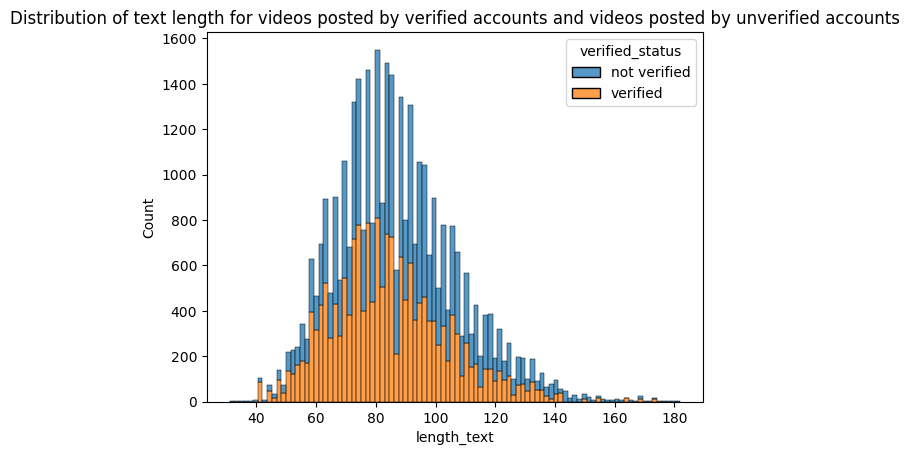

In [22]:
# Visualize the distribution of `video_transcription_text` length for videos posted by verified accounts and videos posted by unverified accounts
# Create two histograms in one plot
sns.histplot(data=data_upsampled, x="length_text", hue="verified_status", multiple='stack')
plt.title("Distribution of text length for videos posted by verified accounts and videos posted by unverified accounts")

## Examine correlations

In [23]:
# Code a correlation matrix to help determine most correlated variables
data_upsampled.corr(numeric_only=True)

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,length_text
#,1.000000,-0.000853,-0.011729,-0.697007,-0.581483,-0.504015,-0.487096,-0.413799,-0.193677
video_id,-0.000853,1.000000,0.011859,0.002554,0.006507,0.010515,0.008753,0.013983,-0.007083
video_duration_sec,-0.011729,0.011859,1.000000,0.013589,0.004890,0.002206,0.003989,-0.004586,-0.002981
video_view_count,-0.697007,0.002554,0.013589,1.000000,0.832832,0.711313,0.690048,0.583485,0.244693
video_like_count,-0.581483,0.006507,0.004890,0.832832,1.000000,0.850053,0.828082,0.706140,0.202386
video_share_count,-0.504015,0.010515,0.002206,0.711313,0.850053,1.000000,0.710117,0.620182,0.171651
video_download_count,-0.487096,0.008753,0.003989,0.690048,0.828082,0.710117,1.000000,0.857679,0.173396
video_comment_count,-0.413799,0.013983,-0.004586,0.583485,0.706140,0.620182,0.857679,1.000000,0.149750
length_text,-0.193677,-0.007083,-0.002981,0.244693,0.202386,0.171651,0.173396,0.149750,1.000000


Text(0.5, 1.0, 'Heatmap of dataset')

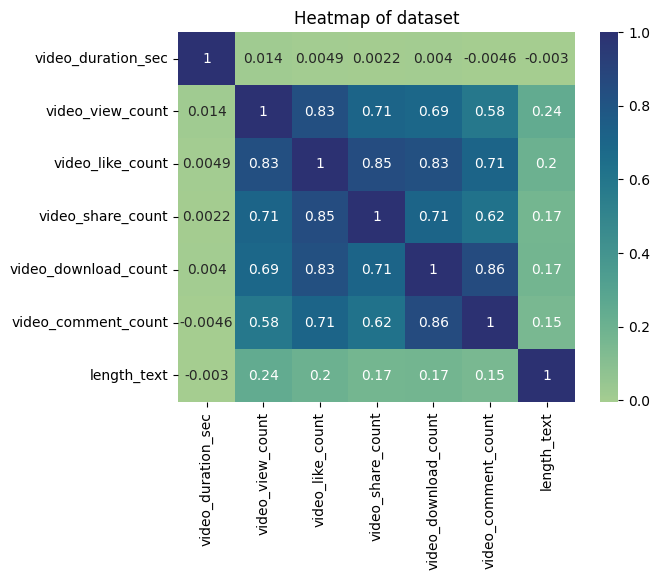

In [24]:
# Create a heatmap to visualize how correlated variables are
sns.heatmap(
    data_upsampled[["video_duration_sec", "claim_status", "author_ban_status", "video_view_count", 
                    "video_like_count", "video_share_count", "video_download_count", "video_comment_count", "length_text"]]
    .corr(numeric_only=True), 
    annot=True,
    cmap="crest")
plt.title("Heatmap of dataset")

The above heatmap shows that the following pair of variables are strongly correlated: video_comment_count and video_download_count (0.86 correlation coefficient). One of the model assumptions for logistic regression is no severe multicollinearity among the features. 
To build a logistic regression model that meets this assumption, exclude vide_download_count. Among the variables that quantify video metrics, keep video_view_count, video_share_count, vide0_like_count, and video_comment_count as features.

## Construct model 

### Select variables

In [25]:
# Select outcome variable
y=data_upsampled["verified_status"]

In [26]:
# Select features
x=data_upsampled[["video_duration_sec", "claim_status", "author_ban_status","video_view_count", "video_share_count", "video_like_count", "video_comment_count"]]

# Display first few rows of features dataframe
x.head()

,video_duration_sec,claim_status,author_ban_status,video_view_count,video_share_count,video_like_count,video_comment_count
0,59,claim,under review,343296.0,241.0,19425.0,0.0
1,32,claim,active,140877.0,19034.0,77355.0,684.0
2,31,claim,active,902185.0,2858.0,97690.0,329.0
3,25,claim,active,437506.0,34812.0,239954.0,584.0
4,19,claim,active,56167.0,4110.0,34987.0,152.0


### Train-test split

In [28]:
# Split the data into training and testing sets
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=42)

In [29]:
# Get shape of each training and testing set
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((25037, 7), (10731, 7), (25037,), (10731,))

### Encode variables 

In [30]:
# Check data types
x_train.dtypes

video_duration_sec       int64
claim_status            object
author_ban_status       object
video_view_count       float64
video_share_count      float64
video_like_count       float64
video_comment_count    float64
dtype: object

In [31]:
# Get unique values in `claim_status`
x_train["claim_status"].unique()

array(['opinion', 'claim'], dtype=object)

In [32]:
# Get unique values in `author_ban_status`
x_train["author_ban_status"].unique()

array(['active', 'banned', 'under review'], dtype=object)

Categorical features must be changed to numerical through encoding

In [33]:
# Select the training features that needs to be encoded
x_to_encode=x_train[["author_ban_status", "claim_status"]]

# Display first few rows
x_to_encode.head()

,author_ban_status,claim_status
33627,active,opinion
32177,banned,opinion
17038,active,opinion
91,banned,claim
25378,active,opinion


In [34]:
# Set up an encoder for one-hot encoding the categorical features
x_encoder=OneHotEncoder(drop='first',sparse_output=False)

In [35]:
# Fit and transform the training features using the encoder
x_train_encoded=x_encoder.fit_transform(x_to_encode)

In [36]:
# Get feature names from encoder
x_encoder.get_feature_names_out()

array(['author_ban_status_banned', 'author_ban_status_under review',
       'claim_status_opinion'], dtype=object)

In [37]:
# Display first few rows of encoded training features
x_train_encoded

array([[0., 0., 1.],
       [1., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [38]:
# Place encoded training features (which is currently an array) into a dataframe
x_train_encoded=pd.DataFrame(data=x_train_encoded,columns=x_encoder.get_feature_names_out())

# Display first few rows
x_train_encoded.head()

,author_ban_status_banned,author_ban_status_under review,claim_status_opinion
0,0.0,0.0,1.0
1,1.0,0.0,1.0
2,0.0,0.0,1.0
3,1.0,0.0,0.0
4,0.0,0.0,1.0


In [39]:
# Display first few rows of `X_train` with `claim_status` and `author_ban_status` columns dropped (since these features are being transformed to numeric)
x_train.drop(columns=["claim_status","author_ban_status"]).head()

,video_duration_sec,video_view_count,video_share_count,video_like_count,video_comment_count
33627,38,9010.0,1340.0,3560.0,24.0
32177,17,4458.0,111.0,356.0,2.0
17038,38,7496.0,542.0,2427.0,5.0
91,37,436875.0,41775.0,260329.0,1947.0
25378,32,6725.0,138.0,905.0,4.0


In [40]:
# Concatenate `X_train` and `X_train_encoded_df` to form the final dataframe for training data (`X_train_final`)
x_train_final=pd.concat([x_train.drop(columns=["claim_status", "author_ban_status"]).reset_index(drop=True),x_train_encoded],axis=1)

# Display first few rows
x_train_final.head()

,video_duration_sec,video_view_count,video_share_count,video_like_count,video_comment_count,author_ban_status_banned,author_ban_status_under review,claim_status_opinion
0,38,9010.0,1340.0,3560.0,24.0,0.0,0.0,1.0
1,17,4458.0,111.0,356.0,2.0,1.0,0.0,1.0
2,38,7496.0,542.0,2427.0,5.0,0.0,0.0,1.0
3,37,436875.0,41775.0,260329.0,1947.0,1.0,0.0,0.0
4,32,6725.0,138.0,905.0,4.0,0.0,0.0,1.0


In [41]:
# Get unique values of outcome variable
y_train.unique()

array(['verified', 'not verified'], dtype=object)

In [42]:
# Set up an encoder for one-hot encoding the categorical outcome variable
y_encoder=OneHotEncoder(drop="first",sparse_output=False)

In [43]:
# Encode the training outcome variable
y_train_final = y_encoder.fit_transform(y_train.values.reshape(-1, 1)).ravel()

# Display the encoded training outcome variable
y_train_final

array([1., 1., 0., ..., 0., 0., 0.])

### Build model 

In [44]:
# Construct a logistic regression model and fit it to the training set
clf=LogisticRegression().fit(x_train_final,y_train_final)

## Evaluate model 

### Encode categorical features in testing set 

In [45]:
# Select the testing features that needs to be encoded
x_test_to_encode=x_test[["author_ban_status", "claim_status"]]

# Display first few rows
x_test_to_encode.head()

,author_ban_status,claim_status
26849,active,opinion
1227,under review,claim
25467,active,opinion
27310,active,opinion
27560,active,opinion


In [46]:
# Transform the testing features using the encoder
x_test_encoded=x_encoder.transform(x_test_to_encode)

# Display first few rows of encoded testing features
x_test_encoded

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [47]:
# Place encoded testing features (which is currently an array) into a dataframe
x_test_encoded_df=pd.DataFrame(data=x_test_encoded,columns=x_encoder.get_feature_names_out())

# Display first few rows
x_test_encoded_df.head()

,author_ban_status_banned,author_ban_status_under review,claim_status_opinion
0,0.0,0.0,1.0
1,0.0,1.0,0.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0


In [48]:
# Display first few rows of `X_test` with `claim_status` and `author_ban_status` columns dropped (since these features are being transformed to numeric)
x_test.drop(["claim_status","author_ban_status"],axis=1).head()

,video_duration_sec,video_view_count,video_share_count,video_like_count,video_comment_count
26849,12,2177.0,168.0,589.0,2.0
1227,43,862507.0,86137.0,358492.0,265.0
25467,13,7457.0,100.0,993.0,2.0
27310,6,6388.0,133.0,1591.0,1.0
27560,34,4075.0,325.0,820.0,4.0


In [49]:
# Concatenate `X_test` and `X_test_encoded_df` to form the final dataframe for training data (`X_test_final`)
x_test_final=pd.concat([x_test.drop(["claim_status","author_ban_status"],axis=1).reset_index(drop=True),x_test_encoded_df],axis=1)

# Display first few rows
x_test_final.head()

,video_duration_sec,video_view_count,video_share_count,video_like_count,video_comment_count,author_ban_status_banned,author_ban_status_under review,claim_status_opinion
0,12,2177.0,168.0,589.0,2.0,0.0,0.0,1.0
1,43,862507.0,86137.0,358492.0,265.0,0.0,1.0,0.0
2,13,7457.0,100.0,993.0,2.0,0.0,0.0,1.0
3,6,6388.0,133.0,1591.0,1.0,0.0,0.0,1.0
4,34,4075.0,325.0,820.0,4.0,0.0,0.0,1.0


### Test regression model 

In [50]:
# Use the logistic regression model to get predictions on the encoded testing set
y_pred=clf.predict(x_test_final)

In [51]:
# Display the predictions on the encoded testing set
y_pred

array([1., 0., 1., ..., 1., 0., 0.])

In [52]:
# Display the true labels of the testing set
y_test

26849        verified
1227     not verified
25467        verified
27310        verified
27560        verified
             ...     
16758    not verified
28583        verified
23163        verified
1580     not verified
7676     not verified
Name: verified_status, Length: 10731, dtype: object

In [53]:
# Encode the testing outcome variable
y_test_final=y_encoder.transform(y_test.values.reshape(-1, 1)).ravel()

# Display the encoded testing outcome variable
y_test_final

array([1., 0., 1., ..., 1., 0., 0.])

In [54]:
# Get shape of each training and testing set
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((25037, 7), (10731, 7), (25037,), (10731,))

### Visualize model results 

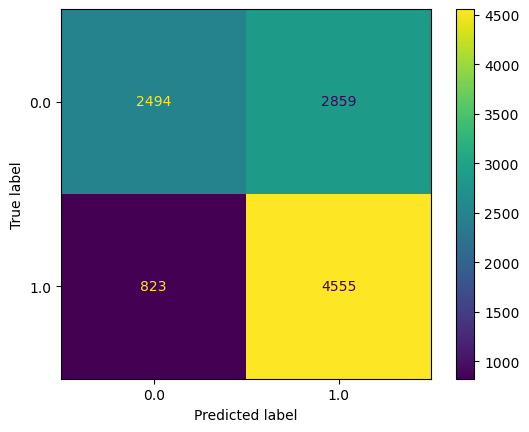

In [55]:
# Compute values for confusion matrix
cm=confusion_matrix(y_test_final,y_pred,labels=clf.classes_)

# Create display of confusion matrix
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)

# Plot confusion matrix
disp.plot()

# Display plot
plt.show()

In [56]:
(4555+2494)/(2494+2859+823+4555)

0.6568819308545336

### Create classification report 

In [58]:
# Create a classification report
target_labels = ["verified", "not verified"]
print(classification_report(y_test_final, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

    verified       0.75      0.47      0.58      5353
not verified       0.61      0.85      0.71      5378

    accuracy                           0.66     10731
   macro avg       0.68      0.66      0.64     10731
weighted avg       0.68      0.66      0.64     10731



The classification report above shows that the logistic regression model achieved a precision of 61% and a recall of 85%, and it achieved an accuracy of 66%.

### Interpret model coefficients

In [59]:
# Get the feature names from the model and the model coefficients (which represent log-odds ratios)
# Place into a DataFrame for readability
pd.DataFrame(data={"Feature Name":clf.feature_names_in_, "Model Coefficient":clf.coef_[0]})

,Feature Name,Model Coefficient
0,video_duration_sec,8.369396e-03
1,video_view_count,-2.388755e-06
2,video_share_count,7.331486e-06
3,video_like_count,-1.247787e-06
4,video_comment_count,8.175188e-05
5,author_ban_status_banned,-1.625782e-05
6,author_ban_status_under review,3.834981e-07
7,claim_status_opinion,3.687596e-04


Based on the estimated model coefficients from the logistic regression, longer videos tend to be associated with higher odds of the user being verified. 
Other video features have small estimated coefficients in the model, so their association with verified status seems to be small.